In [1]:
include("./src/RoutineFunctions.jl")
include("./modules/Thermodynamics.jl")
include("./modules/OpticalCavity.jl")
include("./modules/Phaseonium.jl")
include("./modules/BosonicOperators.jl")
include("./modules/Measurements.jl")

using LinearAlgebra
using ProgressBars
using Plots
using LaTeXStrings

using .Thermodynamics
using .OpticalCavity
using .Phaseonium
using .BosonicOperators
using .Measurements

## Setup Experiment

In [2]:
function kraus_operators(α, ϕ)
    ga, gb = Phaseonium.dissipationrates(α, ϕ)
    
    C = BosonicOperators.C(Ω*Δt, NDIMS)
    Cp = BosonicOperators.Cp(Ω*Δt, NDIMS)
    S = BosonicOperators.S(Ω*Δt, NDIMS)
    Sd = BosonicOperators.Sd(Ω*Δt, NDIMS)
    
    E0 = sqrt(1 - ga/2 - gb/2) * identity(NDIMS) 
    E1 = sqrt(ga/2) * C
    E2 = sqrt(ga) * S
    E3 = sqrt(gb/2) * Cp
    E4 = sqrt(gb) * Sd
    
    return [E0, E1, E2, E3, E4]
end

function _check(ρ)
    println("System after the stroke:")
    if !checkdensity(ρ)
        throw(DomainError(ρ))
    end
    println("Final Temperature of the System: $(Measurements.temperature(ρ, ω))")
end

function measure_and_plot(system_evolution, cavity_evolution, title)
    temperatures = []
    entropies = []
    for (i, ρ) in enumerate(system_evolution)
        local ω = α0 / cavity_evolution[i] 
        t = round(Measurements.temperature(ρ, ω), digits=5)
        ent = round(Measurements.entropy_vn(ρ), digits=5)
        
        push!(temperatures, t)
        push!(entropies, ent)
    end
    
    g = plot(entropies, temperatures, label="Stroke")
    # Plot starting point
    scatter!(g, [entropies[1]], [temperatures[1]], label="Start", mc="blue", ms=5)
    # Plot ending point
    scatter!(g, [entropies[end]], [temperatures[end]], label="End", mc="red", ms=5)
    title!(title)
    xlabel!("Entropy")
    ylabel!("Temperature")
    display(g)
    
    return g
end
;

In [3]:
NDIMS = 40
Ω = 1.0
Δt = 1e-2

T_initial = 1.0
T_heating = 1.5
T_cooling = 0.25

# Create a Cavity
α0 = π
l0 = 1.0
expanding_force = 0.5
compressing_force = 2.5
cavity = Cavity(1.0, 1.0, l0, α0, expanding_force)
ω = α0 / l0

ρt = thermalstate(NDIMS, ω, T_initial)
println(
    "Initial Temperature of the Cavity:
    $(Measurements.temperature(ρt, ω))")

# Jump Operators
a = BosonicOperators.destroy(NDIMS)
ad = BosonicOperators.create(NDIMS)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating
ϕ_h = π/3
α_h = Phaseonium.alpha_from_temperature(T_heating, ϕ_h) 

ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)
println(
    "Apparent Temperature carried by Hot Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_h, gb_h))")

kraus_h = kraus_operators(α_h, ϕ_h)

# Cooling
ϕ_c = π/4
α_c = Phaseonium.alpha_from_temperature(T_cooling, ϕ_c) 

ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
println(
    "Apparent Temperature carried by Cold Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_c, gb_c))")

kraus_c = kraus_operators(α_c, ϕ_c)

# Time Evolution loop
const TT = 20000  # Thermalization Time

system_evolution = []
;

Initial Temperature of the Cavity:
    1.0
Apparent Temperature carried by Hot Phaseonium atoms: 
    4.71238898038469
Apparent Temperature carried by Cold Phaseonium atoms: 
    0.7853981633974483


## 1) Isochoric Stroke

Isochoric Stroke


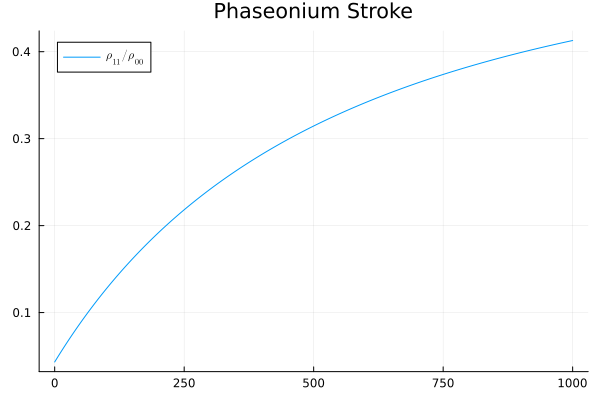

System after the stroke:
Real: true
Diagonal: true
Positive: true
Normal: true
Truncatable: true

Final Temperature of the System: 3.550999693886841


In [4]:
stroke_evolution = Thermodynamics.phaseonium_stroke(ρt, TT, kraus_h; sampling_steps=1000, verbose=2);
append!(system_evolution, stroke_evolution);
ρ = stroke_evolution[end]
chop!(ρ)
_check(ρ)

In [5]:
# See if it has thermalized
# system_final = Thermodynamics.phaseonium_stroke(stroke_evolution[end], 5, kraus_h; sampling_steps=5, verbose=0)[end];
# _check(system_final)

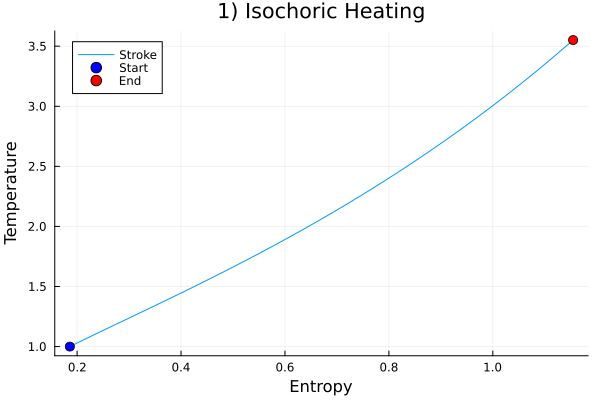

In [6]:
measure_and_plot(stroke_evolution, [cavity.length for _ in stroke_evolution], "1) Isochoric Heating");

## 2) Adiabatic Expansion

Adiabatic Stroke


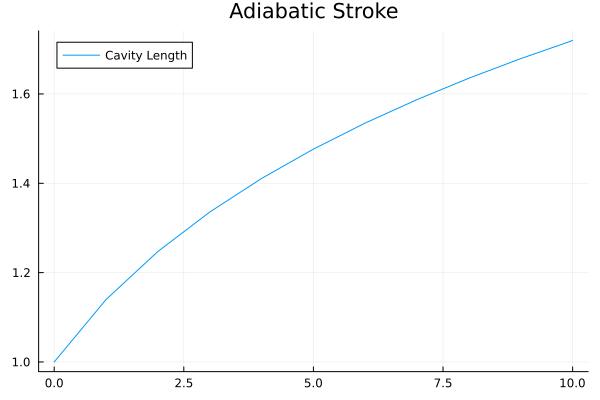

System after the stroke:
Real: true
Diagonal: true
Positive: true
Normal: true
Truncatable: true

Final Temperature of the System: 3.5509996939887345


In [7]:
stroke_evolution, cavity_evolution = Thermodynamics.adiabatic_stroke(ρ, 100, Δt, [a, ad], cavity; 
    sampling_steps=10, verbose=2);
append!(system_evolution, stroke_evolution);
ρ = stroke_evolution[end]
chop!(ρ)
_check(ρ)

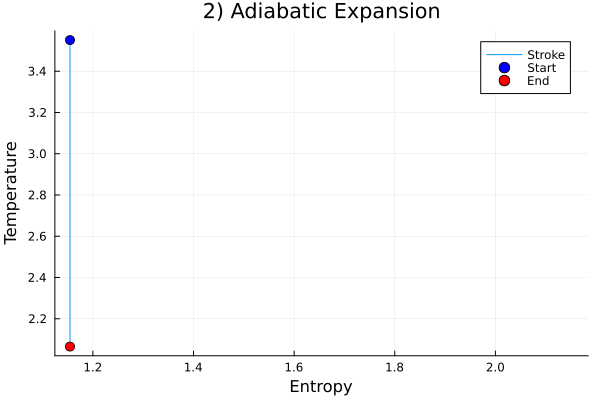

In [8]:
measure_and_plot(stroke_evolution, cavity_evolution, "2) Adiabatic Expansion");

## 3) Isochoric Cooling

Isochoric Stroke


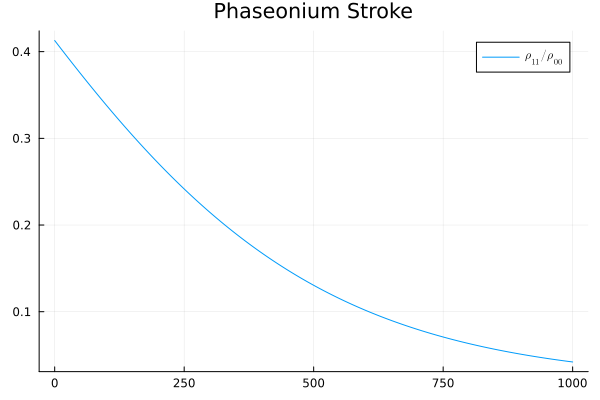

System after the stroke:
Real: true
Diagonal: true
Positive: true
Normal: true
Truncatable: true

Final Temperature of the System: 0.9914077414737367


In [9]:
stroke_evolution = Thermodynamics.phaseonium_stroke(ρ, TT, kraus_c; sampling_steps=1000, verbose=2);
append!(system_evolution, stroke_evolution);
ρ = stroke_evolution[end]
chop!(ρ)
_check(ρ)

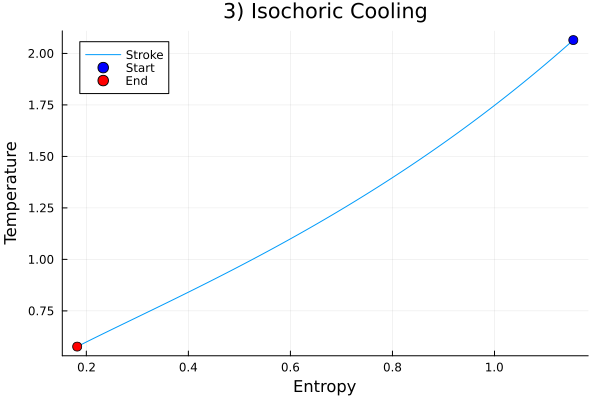

In [10]:
measure_and_plot(stroke_evolution, [cavity.length for _ in stroke_evolution], "3) Isochoric Cooling");

## 4) Adiabatic Compression

Adiabatic Stroke


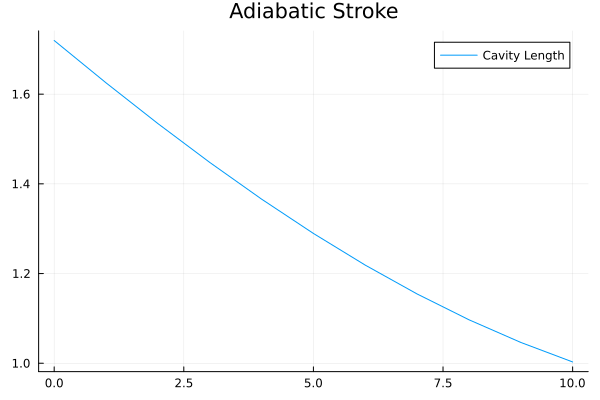

System after the stroke:
Real: true
Diagonal: true
Positive: true
Normal: true
Truncatable: true

Final Temperature of the System: 0.9914077414830565


In [11]:
cavity.external_force = compressing_force
stroke_evolution, cavity_evolution = Thermodynamics.adiabatic_stroke(ρ, 100, Δt, [a, ad], cavity; 
    sampling_steps=10, verbose=2);
append!(system_evolution, stroke_evolution);
ρ = stroke_evolution[end]
chop!(ρ)
_check(ρ)

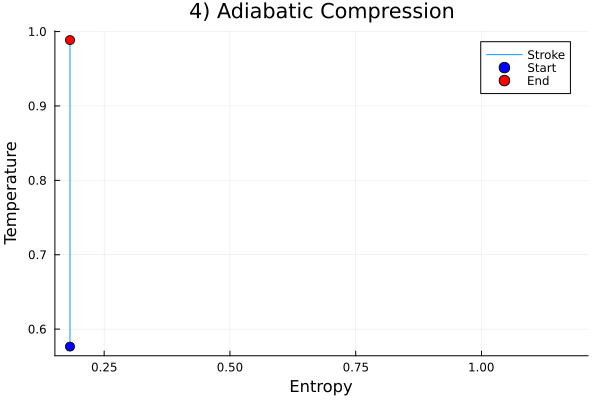

In [12]:
measure_and_plot(stroke_evolution, cavity_evolution, "4) Adiabatic Compression");

## Full Cycle

In [18]:
cycle_evolution = []
cavity_evolution = []
ρ = ρt
isochore_time = 20000
isochore_samplings = 1000
adiabatic_time = 100
adiabatic_samplings = 10
for t in 1:10
    println("Cycle $t")
    # Isochoric Heating
    stroke_evolution = Thermodynamics.phaseonium_stroke(ρ, TT, kraus_h; sampling_steps=isochore_samplings, verbose=1)
    append!(cycle_evolution, stroke_evolution)
    append!(cavity_evolution, [cavity.length for _ in stroke_evolution])
    ρ = stroke_evolution[end]
    chop!(ρ)
    # Adiabatic Expansion
    stroke_evolution, cavity_expansion = Thermodynamics.adiabatic_stroke(ρ, 100, Δt, [a, ad], cavity;
        sampling_steps=adiabatic_samplings, verbose=1)
    append!(cycle_evolution, stroke_evolution)
    append!(cavity_evolution ,cavity_expansion)
    ρ = stroke_evolution[end]
    chop!(ρ)
    # Isochoric Cooling
    stroke_evolution = Thermodynamics.phaseonium_stroke(ρ, TT, kraus_c; sampling_steps=isochore_samplings, verbose=1)
    append!(cycle_evolution, stroke_evolution)
    append!(cavity_evolution, [cavity.length for _ in stroke_evolution])
    ρ = stroke_evolution[end]
    chop!(ρ)
    # Adiabatic Compression
    cavity.external_force = compressing_force
    stroke_evolution, cavity_compression = Thermodynamics.adiabatic_stroke(ρ, 100, Δt, [a, ad], cavity; 
        sampling_steps=adiabatic_samplings, verbose=1)
    append!(cycle_evolution, stroke_evolution)
    append!(cavity_evolution, cavity_compression)
    ρ = stroke_evolution[end]
    chop!(ρ)
end

Cycle 1
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 2
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 3
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 4
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 5
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 6
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 7
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 8
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 9
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke
Cycle 10
Isochoric Stroke
Adiabatic Stroke
Isochoric Stroke
Adiabatic Stroke


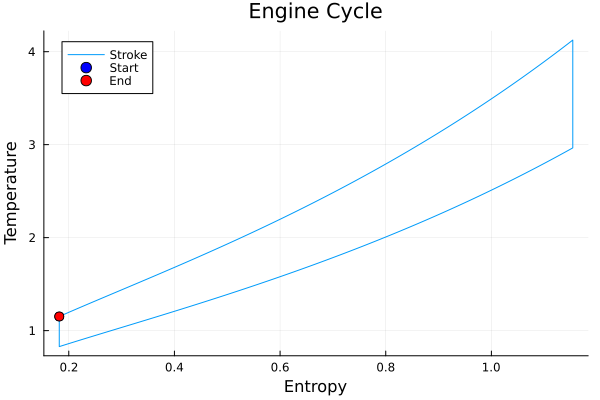

In [48]:
cycle_time = 2*isochore_samplings + 2*adiabatic_samplings + 3
g = measure_and_plot(cycle_evolution[end - cycle_time:end], cavity_evolution[end - cycle_time:end], "Engine Cycle");
savefig("img/phaseonium_engine_cycle");

101-element Vector{Any}:
 ComplexF64[0.9501235464879133 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.04738877865632412 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 2.2965716356164454e-52 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 7.32661123407383e-54 + 0.0im]
 ComplexF64[0.9502241969940217 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.04729815811708903 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 2.172987736374353e-52 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 6.929312301967035e-54 + 0.0im]
 ComplexF64[0.9503245371115691 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.047207796868886036 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 2.0561235368826376e-52 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 6.553774072072223e-54 + 0.0im]
 ComplexF64[0.9504245677302483 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0471176942970986 + 0